<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 6. Redes Neuronales Recurrentes</font></h1>

<h1><font color="#113D68" size=4>2. Series de Tiempo con MLP</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Predicción en series temporales](#section1)
* [2. MLP para regresión](#section2)
    * [2.1. Cargar el dataset](#section2.1)
    * [2.2. Entretamiento](#section2.2)
    * [2.3. Predicción en Y](#section2.3)
    * [2.4. Desarrollo MLP](#section2.4)
    * [2.5. Estimar el rendimiento del modelo](#section2.5)
    * [2.6. Predicciones del modelo](#section2.6)
* [3. MLP mediante el método de ventana](#section3)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En esta lección, aprenderesmo a desarrollar modelos de redes neuronales para la predicción de series de tiempo:
* Predicción de series de tiempo en un ejemplo práctico.
* Desarrollar un modelo de red neuronal para Series temporales.
* Desarrollar un modelo de red neuronal para Series de tiempo con desfase.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Predicción en series temporales</font>

El problema que veremos es un problema de predicción de pasajeros de aerolíneas internacionales. Este es un problema en el que, dado un año y un mes, la tarea es predecir el número de pasajeros de aerolíneas internacionales en unidades de 1.000. Los datos van desde enero de 1949 hasta diciembre de 1960 o 12 años, con 144 observaciones. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre el dataset [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


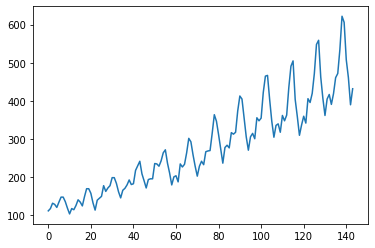

In [17]:
# Declare libraries and dataset
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataset= pd.read_csv(path, usecols=[1], engine='python')
#print(dataset.head(5))

plt.plot(dataset)
plt.show()

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. MLP para regresión</font>

Podemos escribir una función simple para convertir nuestra única columna de datos en un conjunto de datos de dos columnas. La primera columna contiene el recuento de pasajeros $(t)$ de este mes y la segunda columna contiene el recuento de pasajeros $(t + 1)$ del próximo mes (por predecir). 

<a id="section2.1"></a>
# <font color="#004D7F" size=5>2.1. Cargar el dataset</font>

Antes de comenzar, primero importemos todas las funciones y clases que pretendemos usar.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values.astype('float32')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id="section2.2"></a>
# <font color="#004D7F" size=5>2.2. Entretamiento</font>

Con datos de series de tiempo, la secuencia de valores es importante. Un método simple para entrenamiento es dividir el conjunto de datos ordenado en conjuntos de datos de prueba/validación. En este caso vamos a modelarlo en 67% para prueba y 33% para validación.

In [56]:
# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:,:]
print(train.shape,test.shape)

(96, 1) (48, 1)


<a id="section2.3"></a>
# <font color="#004D7F" size=5>2.3. Predicción en $Y$</font>

Ahora podemos definir una función para crear un nuevo conjunto de datos como se describe arriba. 
La función toma dos argumentos:
* El **conjunto de datos,** que es una matriz NumPy y
* La **"vista hacia atrás"**: que es el número de pasos de tiempo anteriores, predeterminado a 1. 
    * Este valor predeterminado creará un conjunto de datos donde $X$ es el número de pasajeros en un momento dado $(t)$ e $Y$ es el número de pasajeros en el siguiente momento $(t + 1)$. 

In [57]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY= [], []
  for i in range(len(dataset)-look_back-1):
    a= dataset[i:i+look_back,0]
    dataX.append(a) 
    dataY.append(dataset[i+look_back,0])
  return np.array(dataX),np.array(dataY)


Si nos fijamos podemos observar el patrón $X = t$ y $Y = t + 1$ en los números. 
```
   X1  Y  
   112 118
   118 132
   132 129
   129 121
   121 135 
```

In [58]:
# reshape into X=t and Y=t+1
look_back= 1
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])

[112.] 118.0
[118.] 132.0
[132.] 129.0
[129.] 121.0
[121.] 135.0


<a id="section2.4"></a>
# <font color="#004D7F" size=5>2.4. Desarrollo MLP</font>

Usamos una red simple:
1. con 1 entrada.
2. 1 capa oculta con 8 neuronas y 
3. 1 capa de salida.
4. El modelo se ajusta usando el error cuadrático medio

In [59]:
# create and fit Multilayer Perceptron model
model= Sequential()
model.add(Dense(12,input_dim=look_back,activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam') 
model.fit(trainX,trainY,epochs=200,batch_size=2,verbose=2)

Epoch 1/200
47/47 - 0s - loss: 24670.7070
Epoch 2/200
47/47 - 0s - loss: 16080.6406
Epoch 3/200
47/47 - 0s - loss: 9675.1611
Epoch 4/200
47/47 - 0s - loss: 5343.2812
Epoch 5/200
47/47 - 0s - loss: 2734.6238
Epoch 6/200
47/47 - 0s - loss: 1400.9579
Epoch 7/200
47/47 - 0s - loss: 819.6792
Epoch 8/200
47/47 - 0s - loss: 614.2923
Epoch 9/200
47/47 - 0s - loss: 563.3843
Epoch 10/200
47/47 - 0s - loss: 546.1310
Epoch 11/200
47/47 - 0s - loss: 542.8926
Epoch 12/200
47/47 - 0s - loss: 543.3578
Epoch 13/200
47/47 - 0s - loss: 537.4470
Epoch 14/200
47/47 - 0s - loss: 538.7791
Epoch 15/200
47/47 - 0s - loss: 539.1053
Epoch 16/200
47/47 - 0s - loss: 541.4995
Epoch 17/200
47/47 - 0s - loss: 540.2184
Epoch 18/200
47/47 - 0s - loss: 547.3076
Epoch 19/200
47/47 - 0s - loss: 542.7973
Epoch 20/200
47/47 - 0s - loss: 537.9315
Epoch 21/200
47/47 - 0s - loss: 543.4280
Epoch 22/200
47/47 - 0s - loss: 547.1977
Epoch 23/200
47/47 - 0s - loss: 541.9493
Epoch 24/200
47/47 - 0s - loss: 544.9515
Epoch 25/200
47/4

<a id="section2.5"></a>
# <font color="#004D7F" size=5>2.5. Estimar el rendimiento del modelo</font>

Una vez que el modelo se ajusta, podemos estimar el rendimiento del modelo en el train/test.

In [60]:
# Estimate model performance
trainScore= model.evaluate(trainX,trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= model.evaluate(testX,testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

Train Score: 531.17 MSE (23.05 RMSE)
Test Score: 2352.70 MSE (48.50 RMSE)


<a id="section2.6"></a>
# <font color="#004D7F" size=5>2.6. Predicciones del modelo</font>

Finalmente, podemos generar predicciones. Los datos se grafican, mostrando el conjunto de datos original en azul, las predicciones de train en verde y las predicciones de test en rojo.

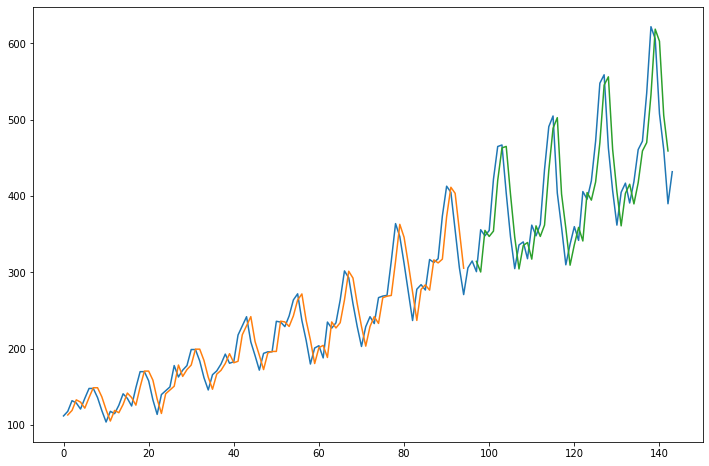

In [61]:
# generate predictions for training
trainPredict= model.predict(trainX)
testPredict= model.predict(testX)

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. MLP mediante el método de ventana</font>

Hacer la predicción para el próximo paso de tiempo se denomina método de ventana y el tamaño de la ventana es un parámetro que se puede ajustar. 

Por ejemplo, dado el tiempo actual $(t)$ que queremos predecir el valor en el próximo tiempo en la secuencia $(t + 1)$, podemos usar el tiempo actual $(t)$ así como los dos tiempos anteriores ($t-1$ y $t-2$). Por tanto: 
* Las variables de entrada son $t-2$, $t-1$, $t$ y 
* La variable de salida es $t + 1$.
Nuestro problema quedaría como:
```
   X1  X2  X3  Y
   112 118 132 129
   118 132 129 121
   132 129 121 135
   129 121 135 148
   121 135 148 148 
```

La función `create_dataset()` permite crear el tamaño de ventana con el argumento `look_back` de 1 a 3.

Agrandamos nuestra arquitectura:
* La primera capa oculta se aumenta a 14 neuronas
* Agregamos una segunda capa oculta con 8 neuronas. 
* El número de épocas se incrementa a 400.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense 

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY= [], []
  for i in range(len(dataset)-look_back-1):
    a= dataset[i:i+look_back,0]
    dataX.append(a) 
    dataY.append(dataset[i+look_back,0])
  return np.array(dataX),np.array(dataY)

# load the dataset
from google.colab import drive
drive.mount('/content/drive')
path= "/content/drive/MyDrive/CursoDeepLearning/Datasets/international-airline-passengers.csv"

dataframe= pd.read_csv(path, usecols=[1], engine='python')
dataset= dataframe.values.astype('float32')

# split into train and test sets
train_size= int(len(dataset)* 0.67)
test_size= len(dataset) - train_size

train, test= dataset[0:train_size,:], dataset[train_size:,:]
print(train.shape,test.shape)

# reshape dataset
look_back= 3
trainX, trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])

# create and fit Multilayer Perceptron model
model= Sequential()
model.add(Dense(12,input_dim=look_back,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam') 
model.fit(trainX,trainY,epochs=200,batch_size=2,verbose=2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(96, 1) (48, 1)
[112. 118. 132.] 129.0
[118. 132. 129.] 121.0
[132. 129. 121.] 135.0
[129. 121. 135.] 148.0
[121. 135. 148.] 148.0
Epoch 1/200
46/46 - 0s - loss: 51194.3906
Epoch 2/200
46/46 - 0s - loss: 32280.9121
Epoch 3/200
46/46 - 0s - loss: 16901.0371
Epoch 4/200
46/46 - 0s - loss: 6050.7373
Epoch 5/200
46/46 - 0s - loss: 1696.4083
Epoch 6/200
46/46 - 0s - loss: 1017.4555
Epoch 7/200
46/46 - 0s - loss: 959.7671
Epoch 8/200
46/46 - 0s - loss: 935.4681
Epoch 9/200
46/46 - 0s - loss: 930.1393
Epoch 10/200
46/46 - 0s - loss: 904.8702
Epoch 11/200
46/46 - 0s - loss: 904.9041
Epoch 12/200
46/46 - 0s - loss: 873.6738
Epoch 13/200
46/46 - 0s - loss: 833.3691
Epoch 14/200
46/46 - 0s - loss: 832.0831
Epoch 15/200
46/46 - 0s - loss: 801.1965
Epoch 16/200
46/46 - 0s - loss: 776.8113
Epoch 17/200
46/46 - 0s - loss: 769.4875
Epoch 18/200
46/46 - 0s - loss: 774.9245
Ep

In [64]:
# Estimate model performance
trainScore= model.evaluate(trainX,trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore,math.sqrt(trainScore)))
testScore= model.evaluate(testX,testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore,math.sqrt(testScore)))

Train Score: 477.18 MSE (21.84 RMSE)
Test Score: 2046.77 MSE (45.24 RMSE)


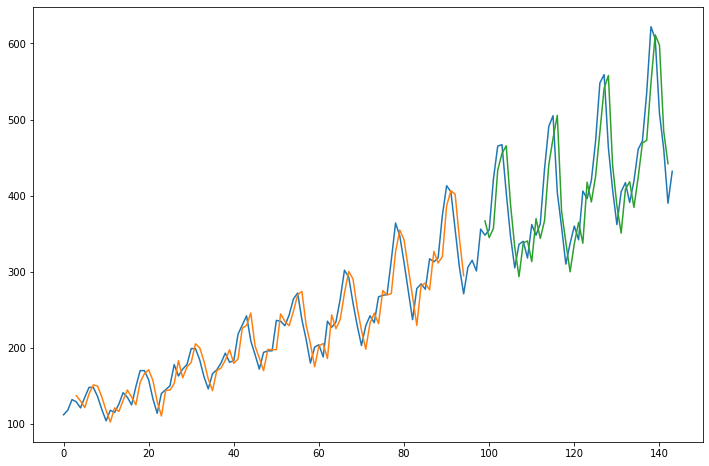

In [65]:
# generate predictions for training
trainPredict= model.predict(trainX)
testPredict= model.predict(testX)

# shift train predictions for plotting
trainPredictPlot= np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back,:]= trainPredict

# shift test predictions for plotting
testPredictPlot= np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1: len(dataset)-1,:]= testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>